
=== Single 30 Hz ===
window=0.200s, NW=3.00, K=5, scale=κ(fs)*sqrt(NW/T) = 13.660794 (κ=3.527202)


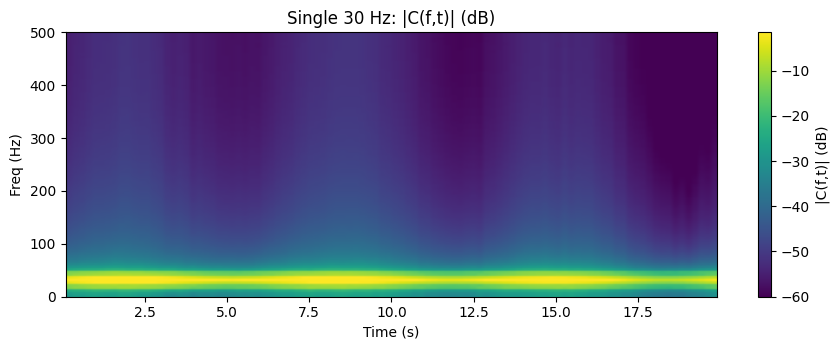

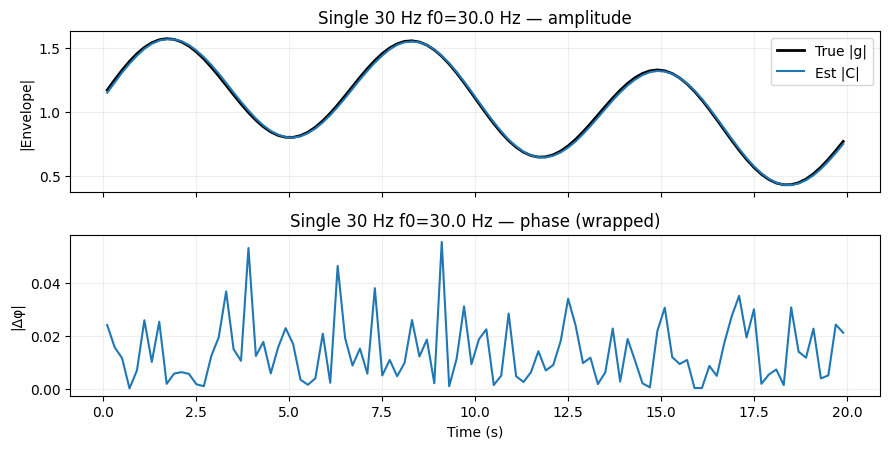

 f0= 30.0 Hz  amp_corr=0.9994  amp_RMSE=0.0121  amp_bias=-0.0026  med|phase_err|=0.011 rad

=== Two tones 12 & 40 Hz ===
window=0.250s, NW=4.00, K=7, scale=κ(fs)*sqrt(NW/T) = 14.108807 (κ=3.527202)


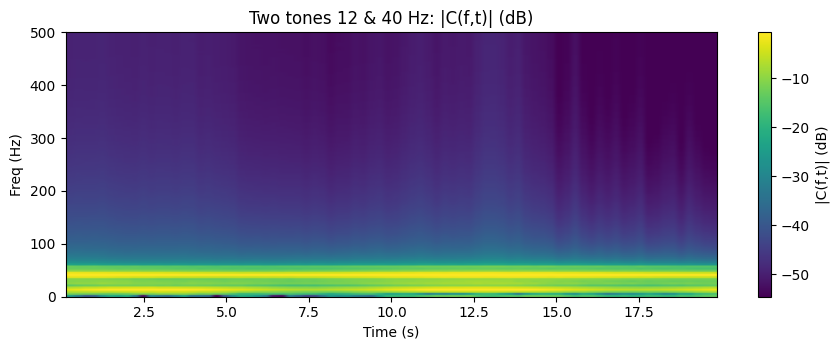

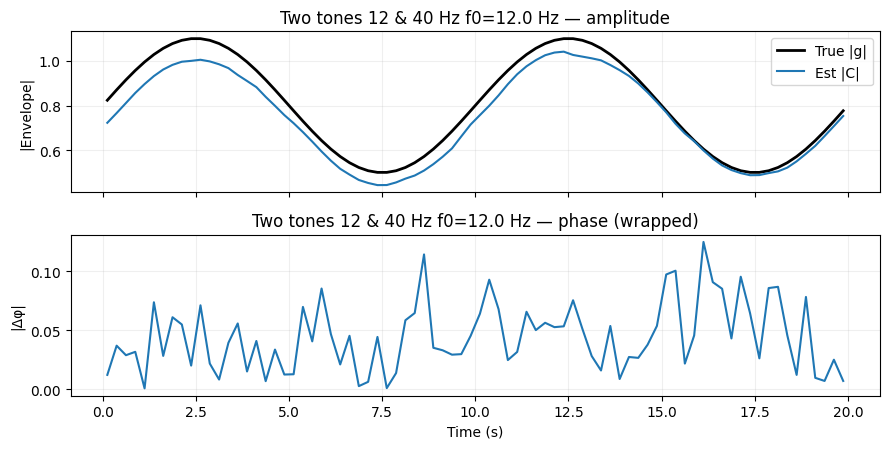

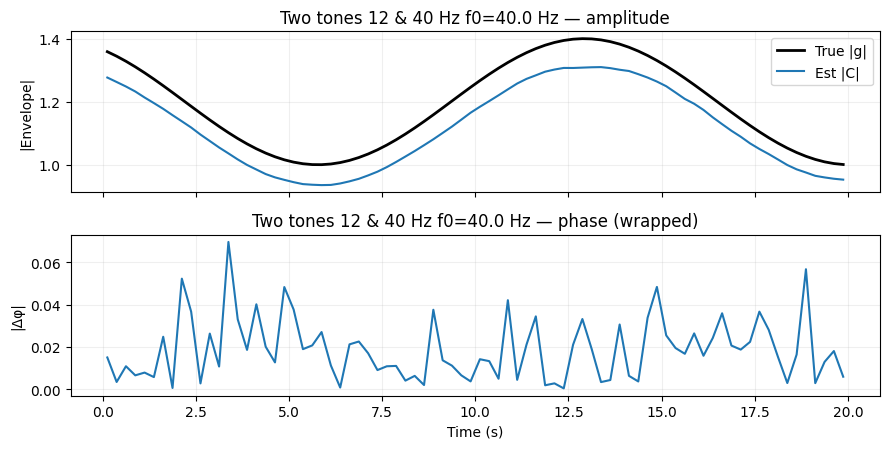

 f0= 12.0 Hz  amp_corr=0.9922  amp_RMSE=0.0612  amp_bias=-0.0534  med|phase_err|=0.041 rad
 f0= 40.0 Hz  amp_corr=0.9983  amp_RMSE=0.0711  amp_bias=-0.0702  med|phase_err|=0.017 rad

=== Three tones 8,20,55 Hz ===
window=0.200s, NW=1.00, K=1, scale=κ(fs)*sqrt(NW/T) = 7.887063 (κ=3.527202)


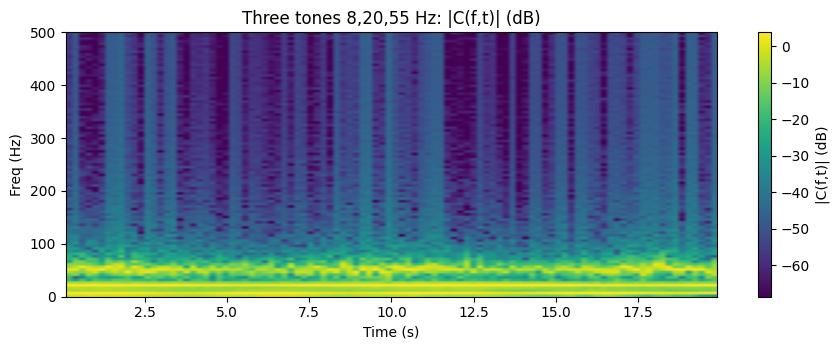

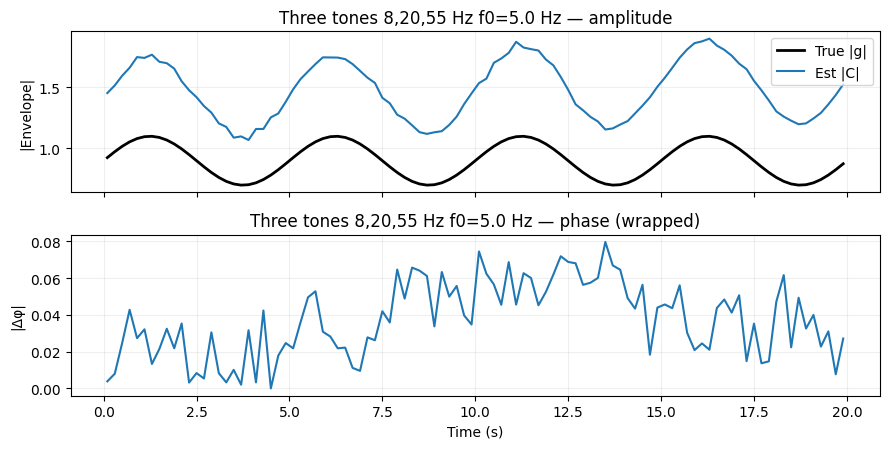

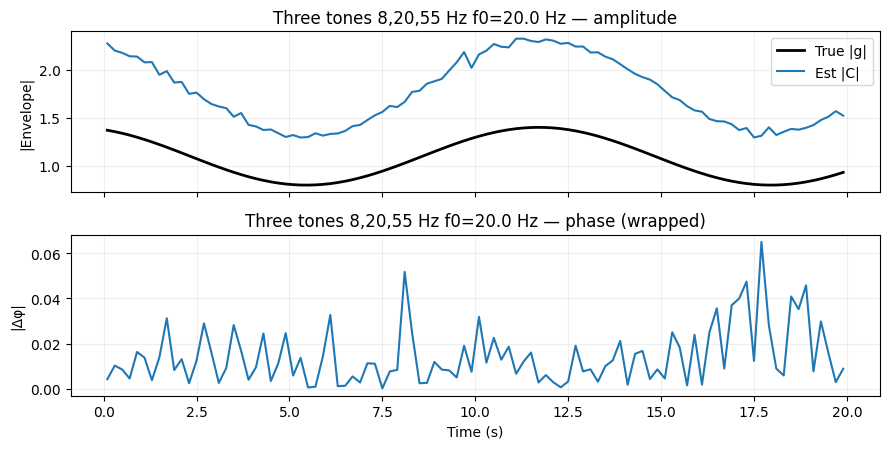

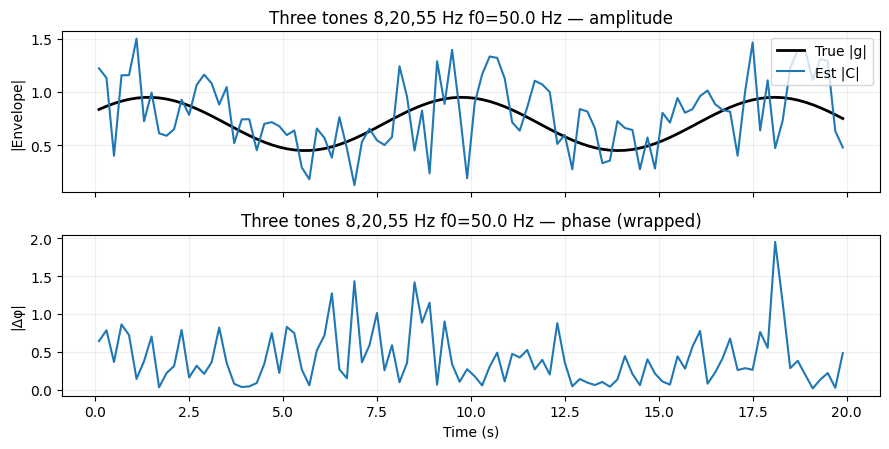

 f0=  5.0 Hz  amp_corr=0.9734  amp_RMSE=0.5869  amp_bias=0.5777  med|phase_err|=0.036 rad
 f0= 20.0 Hz  amp_corr=0.9955  amp_RMSE=0.7060  amp_bias=0.6927  med|phase_err|=0.011 rad
 f0= 50.0 Hz  amp_corr=0.5149  amp_RMSE=0.2854  amp_bias=0.0637  med|phase_err|=0.312 rad


In [ ]:
# ============================================================
# Spynal multitaper: multi-sim tests with amplitude+phase eval
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import spynal.spectra as spy_spec

# ---------- helpers: circular phase math ----------
def wrap(a):               # (-pi, pi]
    return (a + np.pi) % (2*np.pi) - np.pi

def cdiff(a, b):           # shortest angular difference
    return np.arctan2(np.sin(a-b), np.cos(a-b))

# ---------- AR(1) generator for phase increments ----------
def ar1_increments(n, rho=0.98, sigma=0.01, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    e = rng.standard_normal(n) * sigma
    d = np.empty(n); d[0]=e[0]
    for i in range(1, n):
        d[i] = rho*d[i-1] + e[i]
    return d

# ---------- Spynal MT (complex), taper-avg, center-derotate; NO extra scaling ----------
def spynal_tfr_complex(signal, fs, window_sec, NW, removeDC=False, pad=False):
    """
    Returns:
      C_fT_raw: (F,T) complex   (taper-avg, center-derotated)
      freqs   : (F,) Hz
      times   : (T,) s (window centers)
      K       : int  #tapers
    """
    W = NW / window_sec
    K = int(np.floor(2*NW - 1))
    S_raw, freqs, t_cent = spy_spec.spectrogram(
        data=signal[None, :], smp_rate=float(fs), axis=1,
        method='multitaper', spec_type='complex',
        removeDC=bool(removeDC), keep_tapers=True,
        time_width=float(window_sec), spacing=float(window_sec),
        freq_width=float(W), n_tapers=K, pad=bool(pad),
    )
    # (F,K,T); derotate to window center (phase-only; magnitude unaffected)
    S = S_raw[0] * np.exp(1j*2*np.pi*freqs[:, None] * (t_cent[None, :] - window_sec/2))[:, None, :]
    C_fT_raw = S.mean(axis=1)                 # (F,T) taper-average
    return C_fT_raw, np.asarray(freqs, float), np.asarray(t_cent, float), K

# ---------- parameter-only amplitude scaling ----------
_SPYNAL_KAPPA = {}  # cache κ(fs)

def _estimate_kappa(fs, window_ref=0.5, NW_ref=3.0, f_ref=30.0):
    """
    Measure κ(fs) once at a convenient reference (T*, NW*).
    κ = (1/mean|C|) * sqrt(T*/NW*) for a 1-V tone at a grid bin.
    """
    key = float(fs)
    if key in _SPYNAL_KAPPA:
        return _SPYNAL_KAPPA[key]
    M = int(round(window_ref*fs))
    t = np.arange(4*M)/fs
    x = np.cos(2*np.pi*f_ref*t)  # 1-V tone (on-grid if f_ref multiple of fs/M)
    C_ref, _, _, _ = spynal_tfr_complex(x, fs, window_ref, NW_ref, removeDC=False, pad=False)
    mean_mag = float(np.mean(np.abs(C_ref[np.argmin(np.abs(np.fft.rfftfreq(M, 1/fs) - f_ref))])))
    kappa = (1.0 / mean_mag) * np.sqrt(window_ref / NW_ref)
    _SPYNAL_KAPPA[key] = kappa
    return kappa

def apply_global_scale(C_fT_raw, fs, window_sec, NW):
    """Amplitude-correct while preserving correlation: multiply *entire* C_fT by κ(fs)*sqrt(NW/T)."""
    kappa = _estimate_kappa(fs)
    scale = kappa * np.sqrt(NW / window_sec)
    return C_fT_raw * scale, scale, kappa

# ---------- ground-truth builders (on-grid tones to avoid leakage in metrics) ----------
def sim_single(fs, Tsec, f0, A_fun, theta_fun):
    t = np.arange(int(Tsec*fs))/fs
    A = A_fun(t)
    theta = theta_fun(t)
    x = A*np.cos(2*np.pi*f0*t + theta)
    g = A*np.exp(1j*theta)
    return x, t, {f0: g}

def sim_two(fs, Tsec, f1, f2, A1_fun, A2_fun, th1_fun, th2_fun):
    t = np.arange(int(Tsec*fs))/fs
    A1, A2 = A1_fun(t), A2_fun(t)
    th1, th2 = th1_fun(t), th2_fun(t)
    x = A1*np.cos(2*np.pi*f1*t + th1) + A2*np.cos(2*np.pi*f2*t + th2)
    gmap = {f1: A1*np.exp(1j*th1), f2: A2*np.exp(1j*th2)}
    return x, t, gmap

def sim_three(fs, Tsec, freqs, A_funs, th_funs):
    t = np.arange(int(Tsec*fs))/fs
    x = np.zeros_like(t)
    gmap = {}
    for f, A_fun, th_fun in zip(freqs, A_funs, th_funs):
        A, th = A_fun(t), th_fun(t)
        x += A*np.cos(2*np.pi*f*t + th)
        gmap[f] = A*np.exp(1j*th)
    return x, t, gmap

# ---------- evaluation ----------
def eval_amp_phase(C_fT_corr, freqs, times, fs, gmap_true) -> Dict[float, Dict[str, float]]:
    """
    For each ground-truth component at frequency f*, compare:
      amplitude: |C(f*,t)| vs |g_true(t)| (corr, RMSE, bias)
      phase: wrapped error angle(C) - angle(g_true), report median |error|
    Returns dict keyed by f* with metrics.
    """
    tgrid = np.arange(int(times[-1]*fs)+fs)//fs / fs  # coarse helper
    metrics = {}
    for f0, g_true_full in gmap_true.items():
        j = int(np.argmin(np.abs(freqs - f0)))
        C = C_fT_corr[j]                   # (T,)
        # ground-truth at centers (interpolate magnitude & unwrapped phase, then rewrap)
        A_true = np.interp(times, np.arange(len(g_true_full))/fs, np.abs(g_true_full))
        phi_true_unw = np.interp(times, np.arange(len(g_true_full))/fs, np.unwrap(np.angle(g_true_full)))
        phi_true = wrap(phi_true_unw)
        # amplitude metrics
        A_est = np.abs(C)
        eA = A_est - A_true
        amp_corr = float(np.corrcoef(A_est, A_true)[0,1])
        amp_rmse = float(np.sqrt(np.mean(eA**2)))
        amp_bias = float(np.mean(eA))
        # phase metrics
        phi_est = wrap(np.angle(C))
        perr = cdiff(phi_est, phi_true)                 # (-pi,pi]
        phase_med_abs = float(np.median(np.abs(perr)))
        metrics[f0] = dict(amp_corr=amp_corr, amp_rmse=amp_rmse,
                           amp_bias=amp_bias, phase_med_abs=phase_med_abs)
    return metrics

# ---------- plotting ----------
def plot_spectrogram(C_fT_corr, freqs, times, title="Spectrogram (dB)"):
    to_dB = lambda x: 20*np.log10(np.maximum(x, 1e-12))
    P = to_dB(np.abs(C_fT_corr))
    vmin, vmax = np.percentile(P, 5), np.percentile(P, 99)
    plt.figure(figsize=(9,3.6))
    plt.imshow(P, aspect='auto', origin='lower',
               extent=[times[0], times[-1], freqs[0], freqs[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar(label='|C(f,t)| (dB)')
    plt.xlabel("Time (s)"); plt.ylabel("Freq (Hz)"); plt.title(title)
    plt.tight_layout(); plt.show()

def plot_amp_phase(C_fT_corr, freqs, times, fs, gmap_true, label_prefix=""):
    for f0, g_true in gmap_true.items():
        j = int(np.argmin(np.abs(freqs - f0)))
        A_est = np.abs(C_fT_corr[j])
        phi_est = wrap(np.angle(C_fT_corr[j]))
        A_true = np.interp(times, np.arange(len(g_true))/fs, np.abs(g_true))
        phi_true = wrap(np.interp(times, np.arange(len(g_true))/fs, np.unwrap(np.angle(g_true))))
        perr = np.abs(cdiff(phi_est, phi_true))

        fig, axs = plt.subplots(2, 1, figsize=(9,4.6), sharex=True)
        axs[0].plot(times, A_true, 'k', lw=2, label='True |g|')
        axs[0].plot(times, A_est, label='Est |C|'); axs[0].set_ylabel('|Envelope|')
        axs[0].set_title(f"{label_prefix} f0={f0:.1f} Hz — amplitude")
        axs[0].legend(loc='upper right'); axs[0].grid(alpha=0.2)

        axs[1].plot(times, perr, label='|phase error| (rad)')
        axs[1].set_xlabel('Time (s)'); axs[1].set_ylabel('|Δφ|'); axs[1].grid(alpha=0.2)
        axs[1].set_title(f"{label_prefix} f0={f0:.1f} Hz — phase (wrapped)")
        plt.tight_layout(); plt.show()

# ============================================================
#                    RUN MULTI-SIM TESTS
# ============================================================

fs   = 1000.0
pad  = False

tests: List[Tuple[str, dict]] = []

# Test 1: single 30 Hz with slow AM + AR(1) phase
def A1(t): return 1.0 + 0.4*np.sin(2*np.pi*0.15*t) + 0.2*np.sin(2*np.pi*0.03*t + 0.7)
def th1(t):
    d = ar1_increments(t.size, rho=0.98, sigma=0.0001, rng=np.random.default_rng(0))
    return np.cumsum(d) - np.mean(d)
x1, t1, g1 = sim_single(fs, 20.0, 30.0, A1, th1)
tests.append(("Single 30 Hz", dict(x=x1, t=t1, g=g1, window_sec=0.2, NW=3.0)))

# Test 2: two tones (12 and 40 Hz), different envelopes/phases
def A2a(t): return 0.8 + 0.3*np.sin(2*np.pi*0.10*t)
def A2b(t): return 1.2 + 0.2*np.cos(2*np.pi*0.07*t + 0.6)
def th2a(t):
    d = ar1_increments(t.size, rho=0.985, sigma=0.0001, rng=np.random.default_rng(1))
    return np.cumsum(d)
def th2b(t):
    d = ar1_increments(t.size, rho=0.975, sigma=0.0001, rng=np.random.default_rng(2))
    return np.cumsum(d)
x2, t2, g2 = sim_two(fs, 20.0, 12.0, 40.0, A2a, A2b, th2a, th2b)
tests.append(("Two tones 12 & 40 Hz", dict(x=x2, t=t2, g=g2, window_sec=0.25, NW=4.0)))

# Test 3: three tones (8, 20, 55 Hz), stronger phase jitter
def A3a(t): return 0.9 + 0.2*np.sin(2*np.pi*0.20*t)
def A3b(t): return 1.1 + 0.3*np.cos(2*np.pi*0.08*t + 0.4)
def A3c(t): return 0.7 + 0.25*np.sin(2*np.pi*0.12*t + 0.5)
def th3c(t):
    d = ar1_increments(t.size, rho=0.96, sigma=0.010, rng=np.random.default_rng(3))
    return np.cumsum(d)
x3, t3, g3 = sim_three(fs, 20.0, [5.0, 20.0, 50.0],
                       [A3a, A3b, A3c],
                       [th2a, th2b, th3c])
tests.append(("Three tones 8,20,55 Hz", dict(x=x3, t=t3, g=g3, window_sec=0.2, NW=1.0)))

# -------------- run each test: TFR -> global scaling -> eval+plots --------------
for name, cfg in tests:
    x     = cfg["x"]
    t_sig = cfg["t"]
    gmap  = cfg["g"]
    T_w   = cfg["window_sec"]
    NW    = cfg["NW"]

    # spynal complex TFR (taper-avg, center-derotated)
    C_raw, freqs, times, K = spynal_tfr_complex(x, fs, T_w, NW, removeDC=False, pad=pad)
    # apply parameter-only global gain (keeps correlation)
    C_corr, scale, kappa = apply_global_scale(C_raw, fs, T_w, NW)

    print(f"\n=== {name} ===")
    print(f"window={T_w:.3f}s, NW={NW:.2f}, K={K}, scale=κ(fs)*sqrt(NW/T) = {scale:.6f} (κ={kappa:.6f})")

    # spectrogram plots (dB)
    plot_spectrogram(C_corr, freqs, times, title=f"{name}: |C(f,t)| (dB)")

    # amplitude+phase plots per component + metrics
    plot_amp_phase(C_corr, freqs, times, fs, gmap, label_prefix=name)
    m = eval_amp_phase(C_corr, freqs, times, fs, gmap)
    for f0, mm in m.items():
        print(f" f0={f0:>5.1f} Hz  amp_corr={mm['amp_corr']:.4f}  amp_RMSE={mm['amp_rmse']:.4f}  "
              f"amp_bias={mm['amp_bias']:.4f}  med|phase_err|={mm['phase_med_abs']:.3f} rad")
